In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor
# from xgboost import XGBRegressor
import warnings

In [2]:
data = pd.read_csv('data/StudentsPerformance.csv')

In [3]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


#### Aim: 
> To predict the math score, taking all other columns as independent features

In [4]:
X = data.drop(columns=['math score'], axis=1) # Thus, dropping "math score" in input features
    # "axis": the axis along which the operation should be performed in pandas.
    # "axis=0" -> rows & "axis=1" -> columns

X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [5]:
y = data['math score']
y.head()

0    72
1    69
2    90
3    47
4    76
Name: math score, dtype: int64

In [6]:
print("Categories in `gender` variable:\t", data['gender'].unique())

print("Categories in `race/ethnicity` variable:\t", data['race/ethnicity'].unique())

print("Categories in `parental level of education` variable:\t", data['parental level of education'].unique())

print("Categories in `lunch` variable:\t", data['lunch'].unique())

print("Categories in `test preparation course` variable:\t", data['test preparation course'].unique())

Categories in `gender` variable:	 ['female' 'male']
Categories in `race/ethnicity` variable:	 ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in `parental level of education` variable:	 ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in `lunch` variable:	 ['standard' 'free/reduced']
Categories in `test preparation course` variable:	 ['none' 'completed']


In [7]:
# Feature Engineering

numerical_features = X.select_dtypes(exclude="object").columns
categorical_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# initialize onehotencoder & standardscaler
numerical_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

#### "ColumnTransformer" takes a list of tuples, where each tuple contains:
- A name for the transformer (e.g., "OneHotEncoder").

- The transformer object (e.g., oh_transformer).

- The columns that the transformer should be applied to (e.g., categorical_features).

#### The ColumnTransformer will combine/execute OneHotEncoding & StandardScaling together, one after the other, in a "Pipeline"

In [8]:
preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, categorical_features),
        ("StandardScaler", numerical_transformer, numerical_features)
    ]
)

> So, basically this "preprocessor" can be used to fit/transform on any kind of dataset

In [9]:
X = preprocessor.fit_transform(X)
X # gives the final resulting dataframe, after "OHE" & "SC"

array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.19399858,  0.39149181],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         1.42747598,  1.31326868],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.77010859,  1.64247471],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.12547206, -0.20107904],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.60515772,  0.58901542],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.15336989,  1.18158627]])

In [10]:
X.shape

(1000, 19)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((800, 19), (200, 19))

#### function to see model evaluation metrics

In [12]:
def evaluate_model(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse) # root mse
    r_square = r2_score(actual, predicted)
    return mae, rmse, r_square

In [13]:
# list of model
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    # "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

model_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i] # get individual model one-by-one
    model.fit(X_train, y_train) # train that model

    # making predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # getting the "Evaluation Metrics" -> for "Train" & "Test" set
    train_mae, train_rmse, train_r_square = evaluate_model(y_train, y_train_pred)
    test_mae, test_rmse, test_r_square = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(train_mae))
    print("- R2 Score: {:.4f}".format(train_r_square))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(test_mae))
    print("- R2 Score: {:.4f}".format(test_r_square))
    r2_list.append(test_r_square)

    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3243
- Mean Absolute Error: 4.2671
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3960
- Mean Absolute Error: 4.2158
- R2 Score: 0.8803


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5938
- Mean Absolute Error: 5.2063
- R2 Score: 0.8071
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.5197
- Mean Absolute Error: 5.1579
- R2 Score: 0.8253


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.3233
- Mean Absolute Error: 4.2650
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3904
- Mean Absolute Error: 4.2111
- R2 Score: 0.8806


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.7077
- Mean Absolute Error: 4.5167
- R2 Score: 0.8555
-----------------------

### Lets get the Results (& select the best model based on R2_Score)

In [14]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.880593
0,Linear Regression,0.880345
6,CatBoosting Regressor,0.851632
5,Random Forest Regressor,0.849185
7,AdaBoost Regressor,0.844605
1,Lasso,0.825320
3,K-Neighbors Regressor,0.783813
4,Decision Tree,0.732245


In [16]:
# lets go with LinearRegression Model

linreg_model = LinearRegression(fit_intercept=True)
linreg_model = linreg_model.fit(X_train, y_train)
y_pred = linreg_model.predict(X_test)
score = r2_score(y_test, y_pred) * 100
print("Accuracy of the model is %.2f" %score)

Accuracy of the model is 88.03


<Axes: xlabel='math score'>

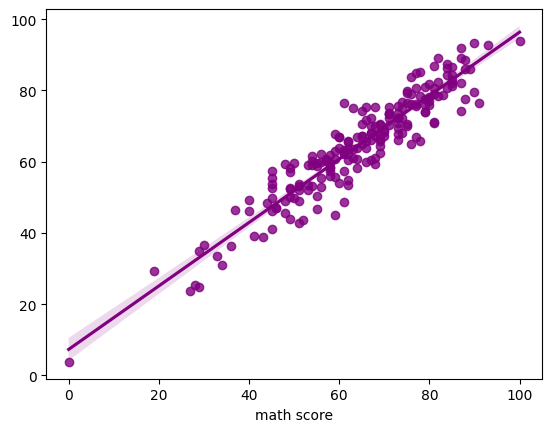

In [17]:
# plotting the regression plot
sns.regplot(x = y_test, y = y_pred, color='purple')

In [21]:
# to see the actual & predicted values
# pd.DataFrame(list(zip(data['math score'], y_pred)), columns=['Actual Value', 'Predicted Value'])
pd.DataFrame({
    'Actual Value': y_test,
    'Predicted Value': y_pred,
    'Difference': y_test - y_pred
})

,Actual Value,Predicted Value,Difference
521,91,76.507812,14.492188
737,53,58.953125,-5.953125
740,80,76.960938,3.039062
660,74,76.757812,-2.757812
411,84,87.539062,-3.539062
...,...,...,...
408,52,43.546875,8.453125
332,62,62.031250,-0.031250
208,74,67.976562,6.023438
613,65,67.132812,-2.132812
